In [1]:
!!pip install gradio==3.45.0



['Collecting gradio==3.45.0',
 '  Downloading gradio-3.45.0-py3-none-any.whl (20.2 MB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/20.2 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.3/20.2 MB\x1b \x1b9.6 MB/s\x1b eta \x1b0:00:03\x1b',
 '\x1b[2K     \x1b━━━━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b4.9/20.2 MB\x1b \x1b73.6 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━\x1b \x1b12.4/20.2 MB\x1b \x1b209.8 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╺\x1b \x1b19.9/20.2 MB\x1b \x1b214.2 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b \x1b20.2/20.2 MB\x1b \x1b207.1 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b \x1b20.2/20.2 MB\x1b \x1b207.1 MB/s\x1b eta \x1

In [2]:
import gradio as gr
print(gr.__version__)


3.45.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pathlib
dataset_url = "/content/drive/MyDrive/Plant_Leaf_disease_detec/train"

In [9]:
from pathlib import Path


data_dir = Path('/content/drive/MyDrive/Plant_Leaf_disease_detec/train')


Apple_Apple_scab = list(data_dir.glob('Apple__Apple_scab/*'))

In [10]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7055 files belonging to 14 classes.
Using 5644 files for training.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)

    return image, label

In [13]:
augmented_train_ds = train_ds.map(augment_image)

In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7055 files belonging to 14 classes.
Using 1411 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy']


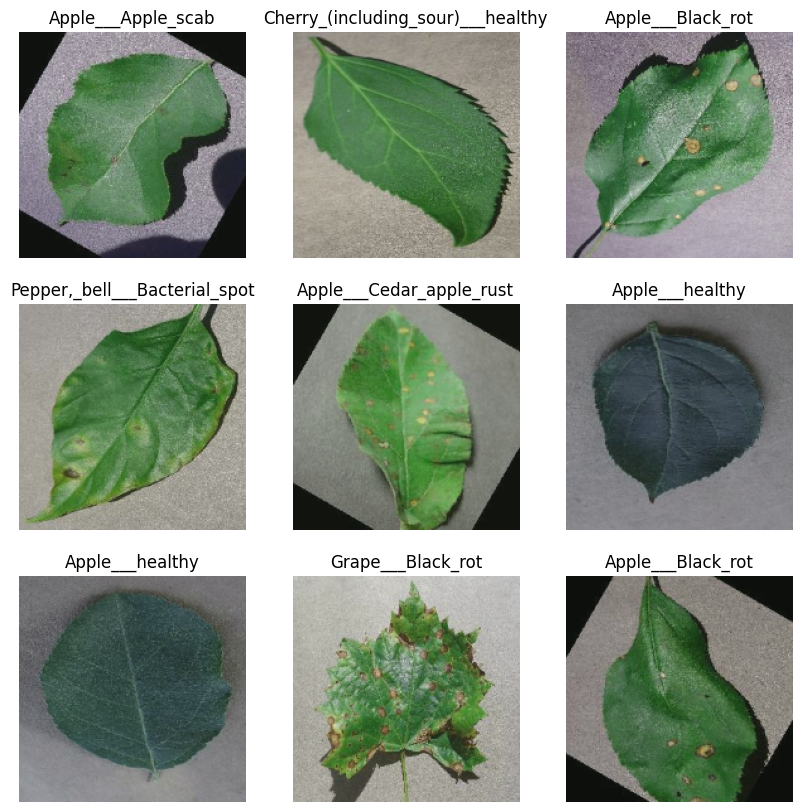

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
num_classes = 14

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs=25
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


177/177 [==============================] - 1180s 7s/step - loss: 2.5352 - accuracy: 0.1324 - val_loss: 2.3194 - val_accuracy: 0.2644
Epoch 2/25
177/177 [==============================] - 24s 136ms/step - loss: 2.0645 - accuracy: 0.2851 - val_loss: 1.6690 - val_accuracy: 0.4288
Epoch 3/25
177/177 [==============================] - 22s 122ms/step - loss: 1.6051 - accuracy: 0.4438 - val_loss: 1.2134 - val_accuracy: 0.5819
Epoch 4/25
177/177 [==============================] - 23s 127ms/step - loss: 1.3159 - accuracy: 0.5356 - val_loss: 0.9845 - val_accuracy: 0.6612
Epoch 5/25
177/177 [==============================] - 21s 117ms/step - loss: 1.1489 - accuracy: 0.5897 - val_loss: 0.8611 - val_accuracy: 0.7094
Epoch 6/25
177/177 [==============================] - 25s 138ms/step - loss: 1.0312 - accuracy: 0.6368 - val_loss: 0.8157 - val_accuracy: 0.7293
Epoch 7/25
177/177 [==============================] - 21s 115ms/step - loss: 0.9115 - accuracy: 0.6875 - val_loss: 0.7010 - val_accuracy: 0.74

In [20]:
import matplotlib.pyplot as plt



In [21]:
import seaborn as sns
def generate_heatmap(model, val_ds):

  predictions = model.predict(val_ds)

  heatmap = np.zeros((predictions.shape[1], predictions.shape[1]))
  for i in range(predictions.shape[0]):
    heatmap += predictions[i]

  heatmap = heatmap / heatmap.sum()

  return heatmap


45/45 [==============================] - 3s 49ms/step


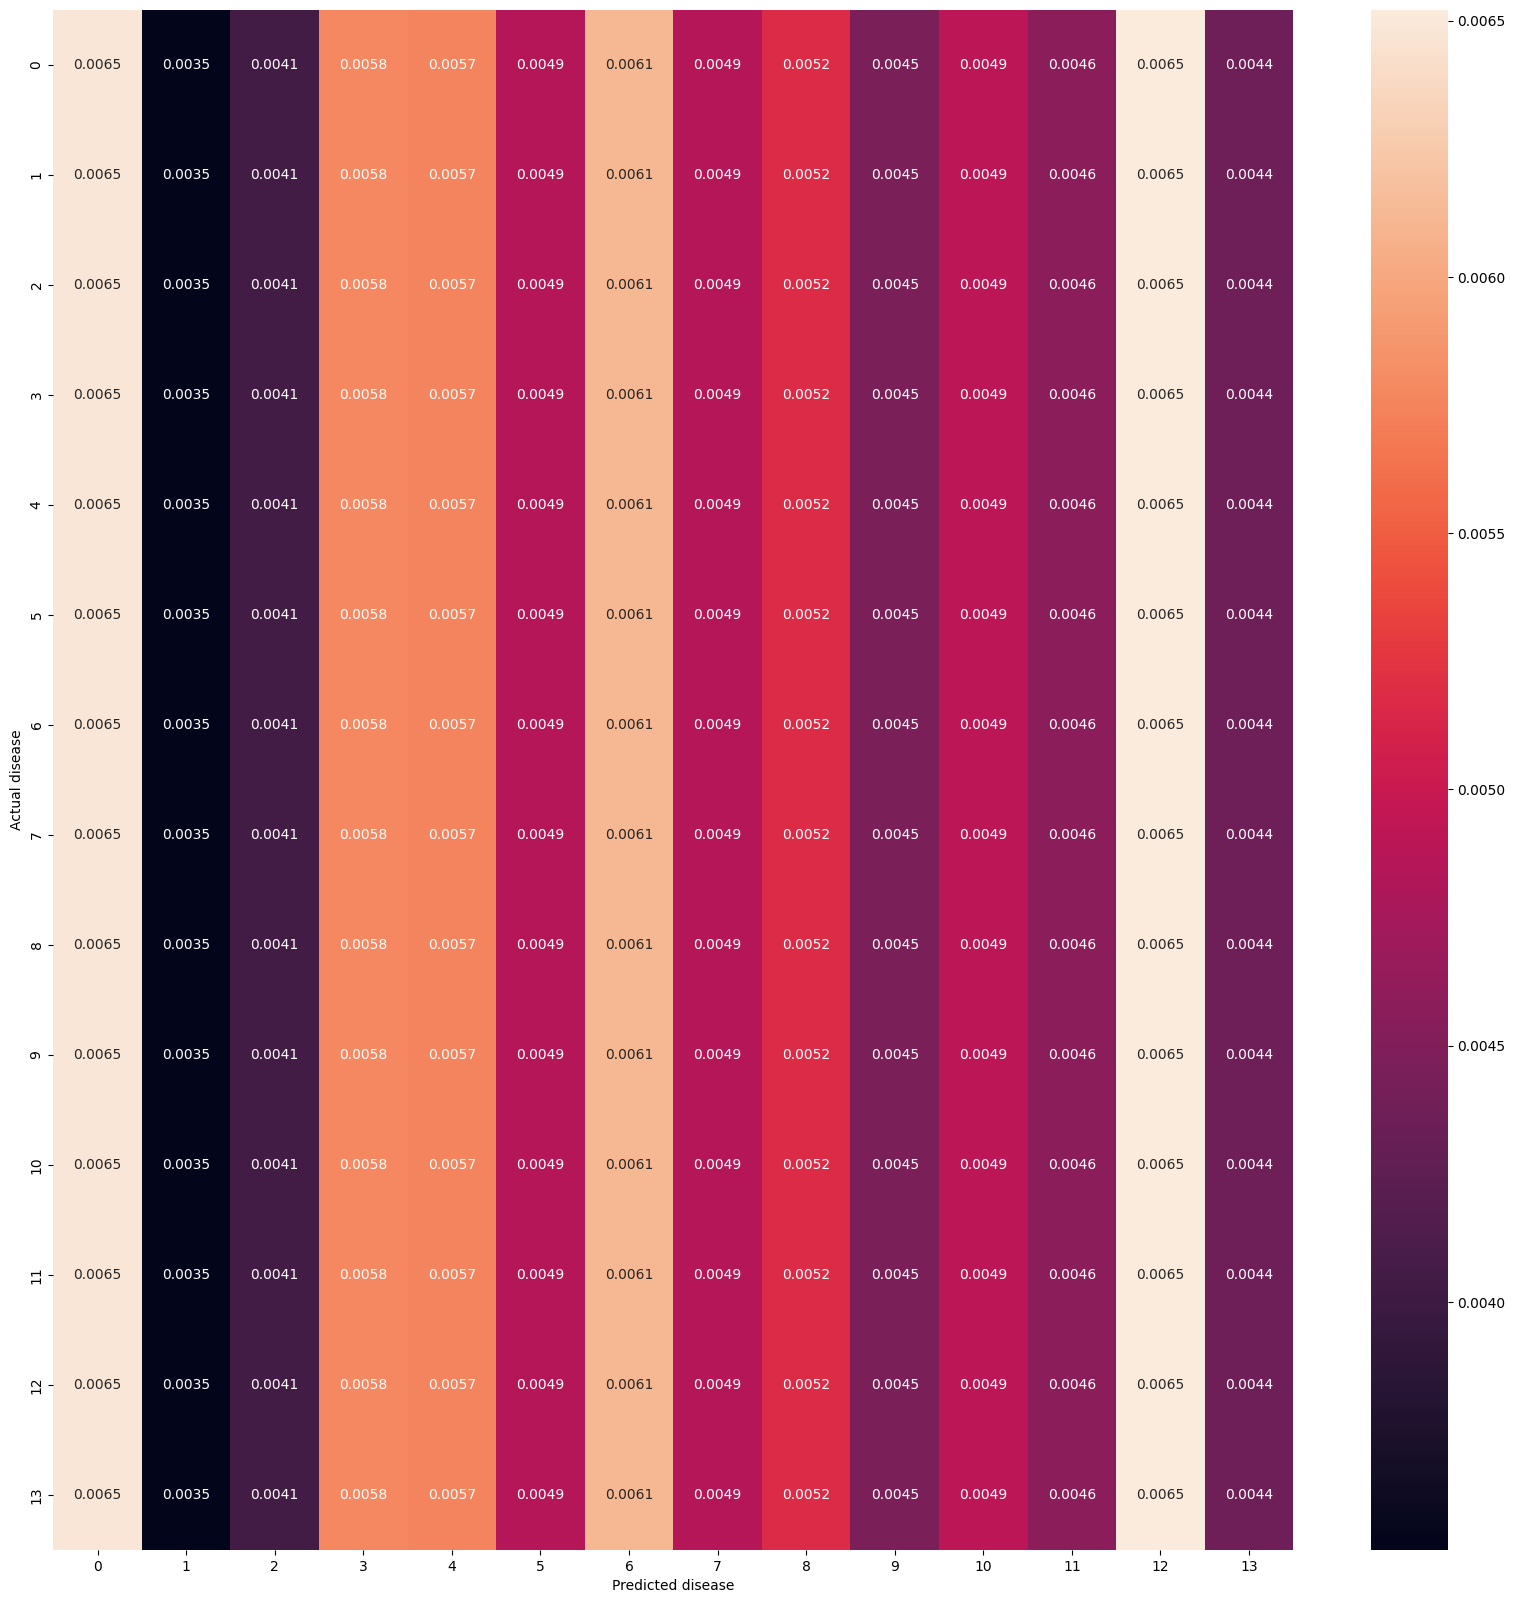

In [22]:
heatmap = generate_heatmap(model, val_ds)

fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(heatmap, ax=ax, annot=True)

ax.set_xlabel('Predicted disease')
ax.set_ylabel('Actual disease')
plt.savefig('/content/drive/MyDrive/Plant_Leaf_disease_detec/heatmap.png')

plt.show()


45/45 [==============================] - 3s 65ms/step
Weighted Precision: 0.07612417335098333
Weighted Recall: 0.07654145995747696
Weighted F1 Score: 0.07592942221420734
Precision for Apple___Apple_scab: 0.06349206349206349
Recall for Apple___Apple_scab: 0.07547169811320754
F1 Score for Apple___Apple_scab: 0.06896551724137931


Precision for Apple___Black_rot: 0.0547945205479452
Recall for Apple___Black_rot: 0.0449438202247191
F1 Score for Apple___Black_rot: 0.04938271604938272


Precision for Apple___Cedar_apple_rust: 0.04878048780487805
Recall for Apple___Cedar_apple_rust: 0.042105263157894736
F1 Score for Apple___Cedar_apple_rust: 0.04519774011299435


Precision for Apple___healthy: 0.10434782608695652
Recall for Apple___healthy: 0.0967741935483871
F1 Score for Apple___healthy: 0.100418410041841


Precision for Cherry_(including_sour)___Powdery_mildew: 0.06422018348623854
Recall for Cherry_(including_sour)___Powdery_mildew: 0.06862745098039216
F1 Score for Cherry_(including_sour)___

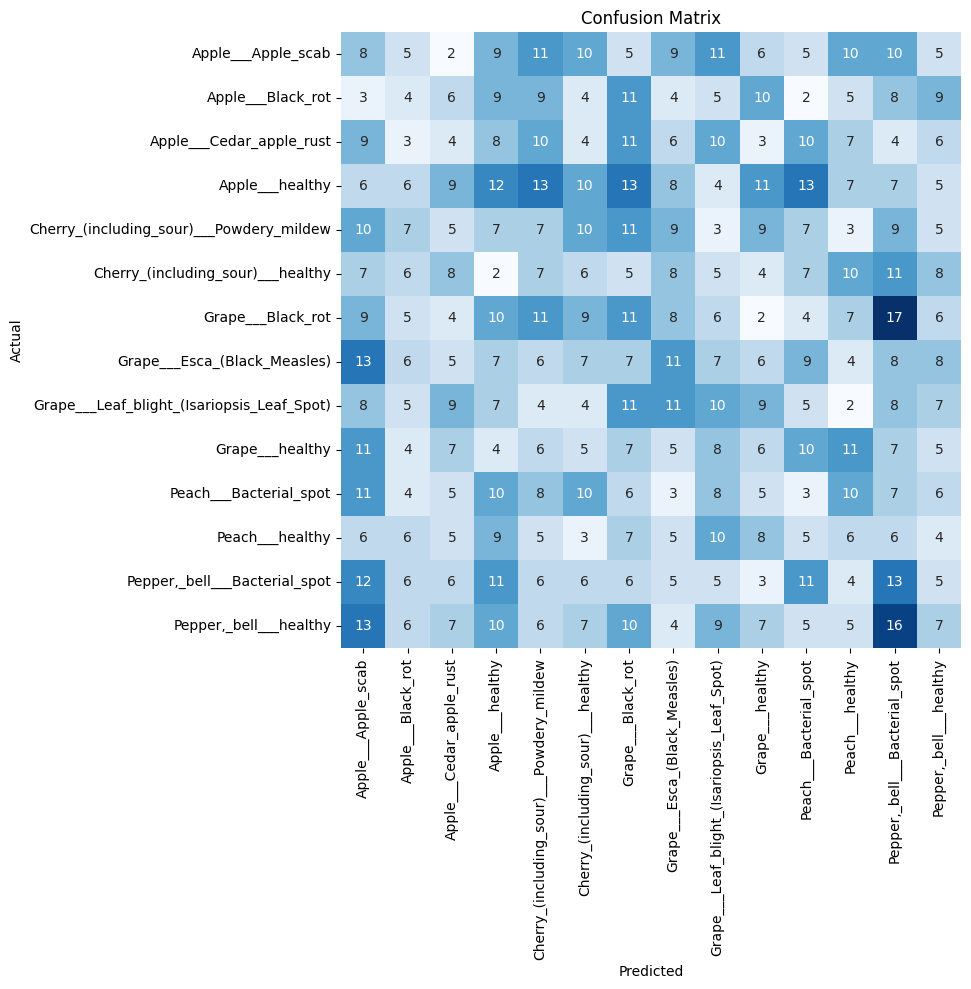

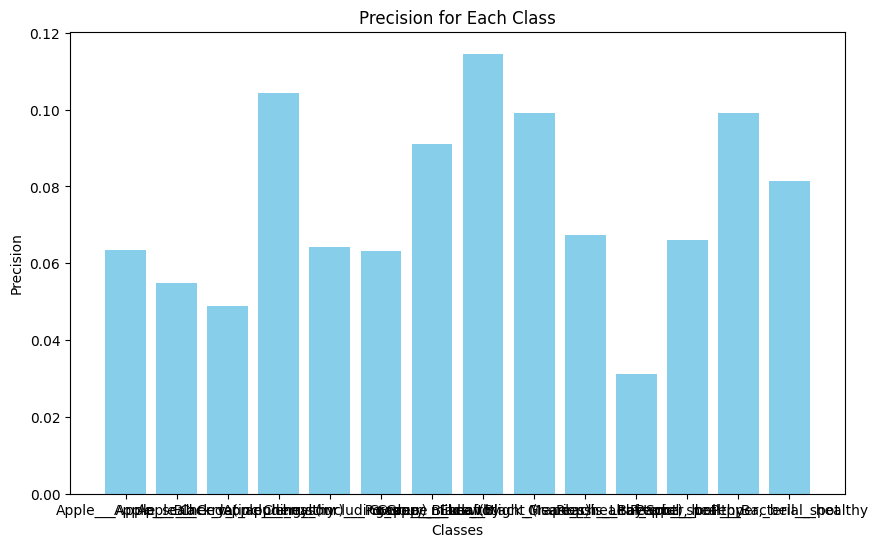

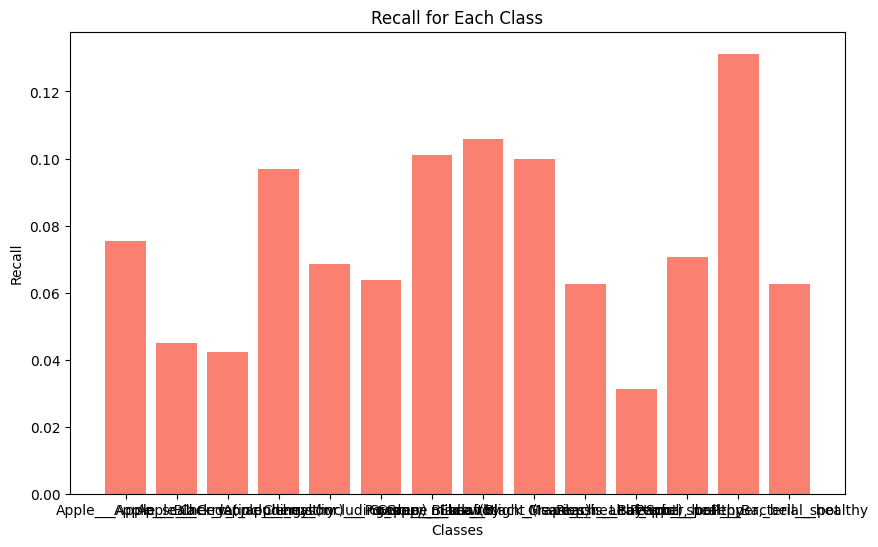

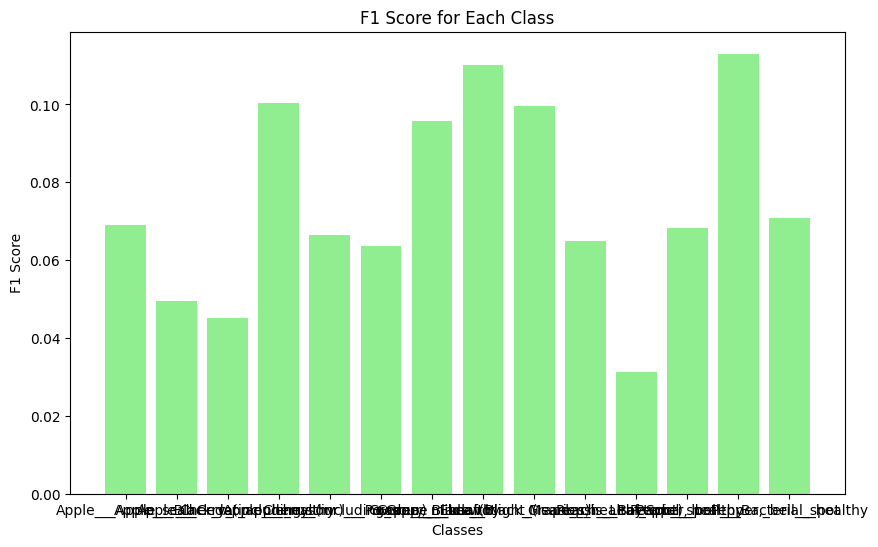

In [24]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

predictions = np.argmax(model.predict(val_ds), axis=-1)

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1)


precision_values = precision_score(true_labels, predictions, average=None)
recall_values = recall_score(true_labels, predictions, average=None)
f1_values = f1_score(true_labels, predictions, average=None)


for i, class_name in enumerate(class_names):
    print(f"Precision for {class_name}: {precision_values[i]}")
    print(f"Recall for {class_name}: {recall_values[i]}")
    print(f"F1 Score for {class_name}: {f1_values[i]}")
    print("\n")

class_report = classification_report(true_labels, predictions, target_names=class_names)
print("Classification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/Plant_Leaf_disease_detec/confusion_matrix.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(class_names, precision_values, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Precision for Each Class')
plt.savefig('/content/drive/MyDrive/Plant_Leaf_disease_detec/precision_graph.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(class_names, recall_values, color='salmon')
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Recall for Each Class')
plt.savefig('/content/drive/MyDrive/Plant_Leaf_disease_detec/recall_graph.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(class_names, f1_values, color='lightgreen')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.savefig('/content/drive/MyDrive/Plant_Leaf_disease_detec/f1_score_graph.png')
plt.show()


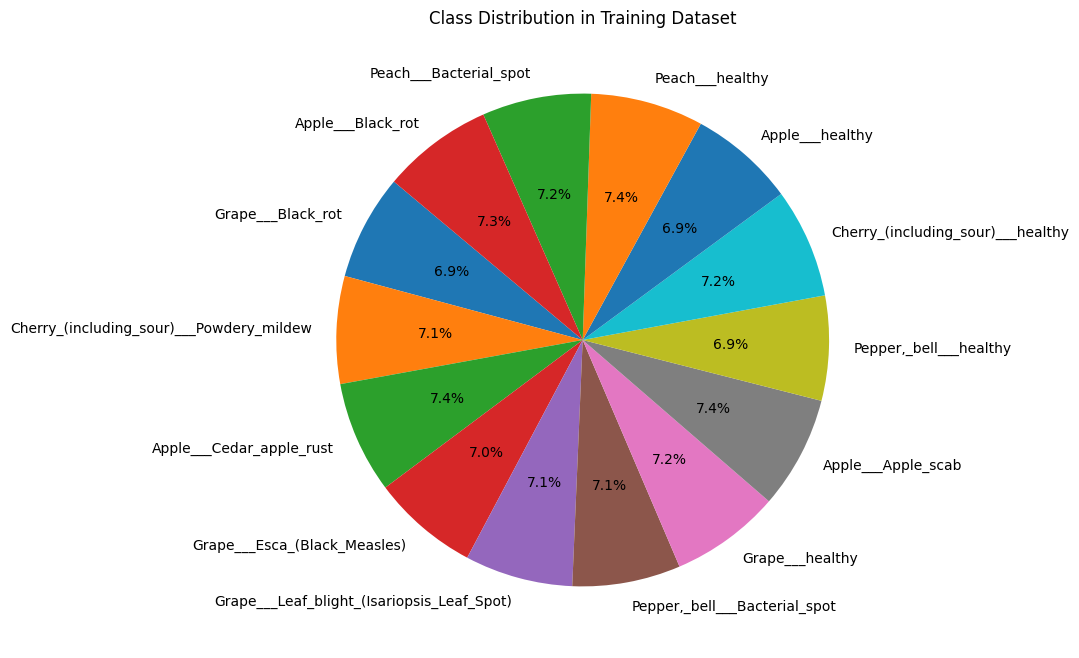

In [25]:
import matplotlib.pyplot as plt

class_counts = {}
for _, labels in train_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Training Dataset')

plt.savefig('/content/drive/MyDrive/Plant_Leaf_disease_detec/pie_chart.png')

plt.show()



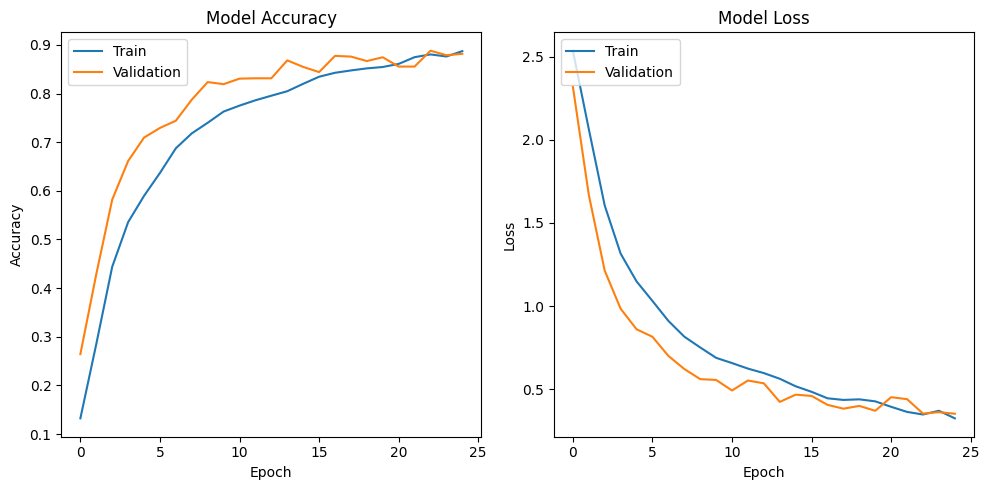

In [26]:

def plot_history_and_save(history, filename):

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()

    plt.savefig(filename)

plot_history_and_save(history, '/content/drive/MyDrive/Plant_Leaf_disease_detec/Model_accuracy_and_loss.png')


In [27]:
!cd /content/drive/MyDrive/Plant_Leaf_disease_detec
model.save('Leaf_disease_detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
import tensorflow as tf
from tensorflow.keras.models import load_model


In [30]:

model= load_model('/content/drive/MyDrive/Plant_Leaf_disease_detec/Leaf_disease_detection.h5')


In [33]:
def predict_image(img):
  img_4d=img.reshape(-1,180,180,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(14)}

In [ ]:
image = gr.inputs.Image(shape=(180,180))
label = gr.outputs.Label(num_top_classes=14)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True', share="True")

<ipython-input-34-c79bc85d0b48>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(180,180))
<ipython-input-34-c79bc85d0b48>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(180,180))
<ipython-input-34-c79bc85d0b48>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=14)
<ipython-input-34-c79bc85d0b48>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=14)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://1262e193d05a337d72.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 18ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 517, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 216, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1555, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1193, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = con

1/1 [==============================] - 0s 21ms/step
